<a href="https://colab.research.google.com/github/DiegoSnach/GLUE-Benchmark/blob/master/1_Final_CoLA_with_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from time import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

In [ ]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='glue/cola', split=['train', 'validation'], batch_size=-1)

In [3]:
train_data.keys()

dict_keys(['idx', 'label', 'sentence'])

In [4]:
df_train = pd.DataFrame(data=train_data)
df_val = pd.DataFrame(data=validation_data)

In [5]:
df_train.loc[df_train['label']==0]

,idx,label,sentence
5,3017,0,b'The inspector analyzed the soundness in the ...
10,4352,0,b'There is more chemical substances involved i...
20,3365,0,b'In the corner lay a dog.'
23,6026,0,b'The cat was being eating.'
24,7931,0,b'The Greeks arrived all.'
...,...,...,...
8539,3682,0,b'John suddenly got the bus off.'
8544,7565,0,b'Mary believes that Bill saw herself.'
8546,4920,0,b'a pencil with that to write broke.'
8547,3619,0,b'It was in the park last night that the polic...


In [6]:
# Creates function to clean data

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  

In [7]:
# Transform data to string as it came as tensor object. Cleans data

sentence = process_data(df_train.sentence.apply(str))
label = df_train.label.apply(int)
print(len(sentence))
print(len(label))

8551
8551


In [8]:
label

0       1
1       1
2       1
3       1
4       1
       ..
8546    0
8547    0
8548    1
8549    0
8550    1
Name: label, Length: 8551, dtype: int64

In [9]:
sentence

0        It is this hat that it is certain that he was...
1        Her efficient looking up of the answer please...
2                 Both the workers will wear carnations '
3        John enjoyed drawing trees for his syntax hom...
4        We consider Leslie rather foolish  and Lou a ...
                              ...                        
8546                  a pencil with that to write broke '
8547     It was in the park last night that the police...
8548           John looked up the inside of the chimney '
8549                         You said she liked yourself'
8550        What we're using is their teaching material  
Name: sentence, Length: 8551, dtype: object

In [10]:
# Transform data to string for validation as well

val_sentence = process_data(df_val.sentence.apply(str))
val_label = df_val.label
print(len(val_sentence))
print(len(val_label))

1043
1043


In [11]:
val_sentence

0                    That picture of Susan offended her '
1                                         I noticed the '
2                         Mary revealed himself to John '
3                    Frank Churchill crossed the street '
4                      Everyone hopes everyone to sleep '
                              ...                        
1038     Smith loaned a valuable collection of manuscr...
1039              I gave it to Pete to take to the fair '
1040     I demand that the more John eat  the more he ...
1041                                        They yelled '
1042                   The person responsible confessed '
Name: sentence, Length: 1043, dtype: object

In [12]:
val_label

0       1
1       0
2       0
3       1
4       0
       ..
1038    1
1039    1
1040    0
1041    1
1042    1
Name: label, Length: 1043, dtype: int64

In [13]:
# Check lenght of sentence

count = sentence.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 8.569173
Median: 8.000000
Max: 43.000000


In [14]:
# Brings Tokenizer and sequences padder

Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer(num_words=20000)
max_len = 32

In [15]:
# Creates vocabulary with all unique tokens

tokenizer.fit_on_texts(list(sentence) + list(val_sentence))
vocab_size = len(tokenizer.word_index) + 1 # Because it counts from 0
print(vocab_size)

5976


In [16]:
# transforms sentences into integers and pads to maxlen

encoded_sentences = tokenizer.texts_to_sequences(sentence)
padded_sentences = pad_sequences(encoded_sentences, maxlen=max_len, padding='post')

# Check
print(sentence[0])
print(encoded_sentences[0])
print(padded_sentences[0])

 It is this hat that it is certain that he was wearing '
[14, 7, 29, 252, 5, 14, 7, 222, 5, 13, 10, 525, 1]
[ 14   7  29 252   5  14   7 222   5  13  10 525   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [17]:
# Same for validation

val_encoded_sentences = tokenizer.texts_to_sequences(val_sentence)
val_padded_sentences = pad_sequences(val_encoded_sentences, maxlen=max_len, padding='post')

# Check
print(val_sentence[0])
print(val_encoded_sentences[0])
print(val_padded_sentences[0])

 That picture of Susan offended her '
[5, 89, 9, 145, 736, 39, 1]
[  5  89   9 145 736  39   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [18]:
# # download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [20]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [21]:
# lists files

!ls "/content/gdrive/My Drive/Glove/glove.6B.300d.txt"

'/content/gdrive/My Drive/Glove/glove.6B.300d.txt'


In [22]:
# Creates dictionary of word embeddings

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/Glove/glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
# Start with the embedding. Randomly initializing the zeros

embedding_dimensions = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector  

In [62]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout1D
from keras import layers

In [77]:
embed = Embedding(vocab_size,embedding_dimensions,weights=[embedding_matrix],input_length=max_len, trainable=False)

n_hidden = 50

In [78]:
model = Sequential()
model.add(embed)
model.add(LSTM(n_hidden, dropout=0.2, activation='tanh', recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           1792800   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 1,863,051
Trainable params: 70,251
Non-trainable params: 1,792,800
_________________________________________________________________


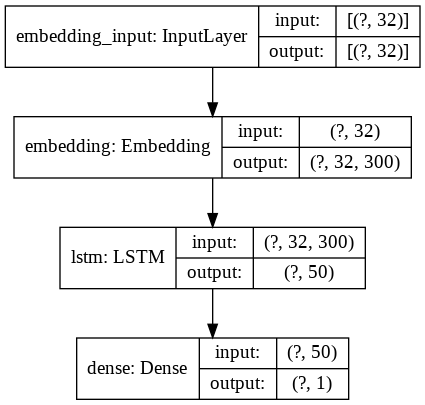

In [72]:
# Plot model graph
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [79]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [80]:
# Classs is imbalanced!! If not addressed the model finds a local minimum at 70
# by adscribing 1 to every example and thus acquiring 70% accuracy

class_weights= {0:3, 1:7}

In [ ]:
# Early stopping to prevent under/over fitting
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')

# Fit the model
history = model.fit(padded_sentences,
                    label,                    
                    epochs=20,
                    batch_size=64,                    
                    class_weight=class_weights,                    
                    validation_split = 0.2,
                    verbose=True,                 
                    callbacks=[earlystop])

In [76]:
# Uncomment and start again from Sequential to 
# Reset weights and retrain model

K.clear_session()
tf.keras.backend.clear_session()

In [138]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [140]:
max(history.history['accuracy'])

0.7211988568305969

In [127]:
# Test evaluation

print("Evaluate on test data")

results = model.evaluate(val_padded_sentences, val_label)

print("test loss, test acc:", results)

Evaluate on test data
33/33 [==============================] - 1s 19ms/step - loss: 0.7420 - accuracy: 0.6903
test loss, test acc: [0.7420401573181152, 0.690316379070282]


In [83]:
prediction = model.predict(val_padded_sentences)

In [84]:
# Adjust it to binary prediction 0 or 1

def binary_prediction (prediction):
  true_preds = []
  for pred in prediction:
    if pred <= 0.5:
      pred = 0
    if pred > 0.5:
      pred = 1
    true_preds.append(pred)
  return true_preds


In [85]:
true_prediction = binary_prediction(prediction=prediction)

In [86]:
## Checking that labels are comparable to do matthews correlation
## Matthews correlation yields a 0, which might be due to inconsistencies in the data

In [87]:
val2 = val_label.to_numpy()

In [144]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(val2, true_prediction)

0.04510120936906261

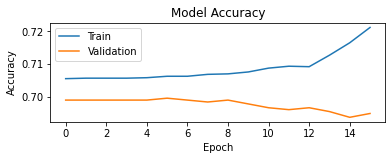

In [143]:
import seaborn as sns

# Plot Accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

In [123]:
# Run 10 experiments and plot results

In [121]:
def make_model():
  tf.keras.backend.clear_session() # Starts session from scratch
  model = Sequential()
  model.add(embed)
  model.add(LSTM(n_hidden, dropout=0.2, activation='tanh', recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))
  # model.summary()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=tf.keras.losses.binary_crossentropy, 
                metrics=['accuracy'])
  model.fit(padded_sentences, 
            label, 
            epochs=20, 
            batch_size=64, 
            class_weight=class_weights, 
            validation_split = 0.2, 
            verbose=2, 
            callbacks=[earlystop])
  results2 = model.evaluate(val_padded_sentences, val_label)
  prediction2 = model.predict(val_padded_sentences)
  true_pred = binary_prediction(prediction=prediction2)
  mat_coef = matthews_corrcoef(val2,true_pred)
  return mat_coef

In [ ]:
colection = [make_model() for _ in range (10)]

In [110]:
real_colection = [i * 100 for i in colection]

In [146]:
real_colection

[4.510120936906261,
 2.1324732257988184,
 -2.339059069282274,
 3.716241204687234,
 5.810041803799692,
 6.413040878862749,
 1.8148342420931134,
 1.3712849373137743,
 6.924068058777889,
 4.63559874942472]

In [117]:
import statistics

In [118]:
median_value = statistics.median(real_colection)

In [119]:
median_value

4.113181070796747

{'boxes': [<matplotlib.lines.Line2D at 0x7f39d5d7b668>],
 'caps': [<matplotlib.lines.Line2D at 0x7f39d5d970b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f39d5d97b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f39d5d977b8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f39d5d7b978>,
  <matplotlib.lines.Line2D at 0x7f39d5d7bcf8>]}

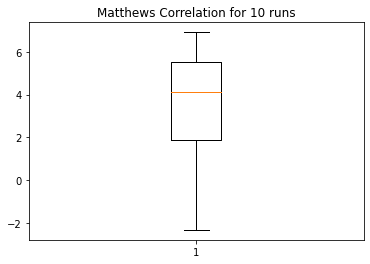

In [145]:
fig1, ax1 = plt.subplots()
ax1.set_title('Matthews Correlation for 10 runs')
ax1.boxplot(real_colection)